In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import bct

from os.path import join
import warnings

from nilearn import plotting
from sklearn.ensemble import IsolationForest

import pycircos
import matplotlib.pyplot as plt
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
warnings.filterwarnings("ignore")

In [3]:
def series_2_nifti(series, out_dir):
    nifti_mapping = pd.read_csv('/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/data/variable_to_nifti_mapping.csv', 
                                header=0, 
                                index_col=0)

    series.index = [x.split('.')[0] for x in series.index]
    #vmin = series.quantile(0.25)

    # list of measures to plot
    measures = {'cortical-thickness': 'smri_thick_cdk_.*',
                'cortical-gwcontrast': 'smri_t1wcnt_cdk_.*',
                'cortical-area': 'smri_area_cdk_.*',
                'cortical-volume': 'smri_vol_cdk_.*', 
                'subcortical-volume': 'smri_vol_scs_.*', 
                'subcortical-RND': 'dmri_rsirnd_scs_.*',
                'subcortical-RNI': 'dmri_rsirni_scs_.*',
                'cortical-RND': 'dmri_rsirndgm_.*',
                'cortical-RNI': 'dmri_rsirnigm_.*',
                'cortical-BOLD-variance': 'rsfmri_var_cdk_.*',
                'tract-volume': 'dmri_dtivol_fiberat_.*', 
                'tract-FA': 'dmri_dtifa_fiberat_.*', 
                'tract-MD': 'dmri_dtimd_fiberat_.*',
                'tract-LD': 'dmri_dtild_fiberat_.*', 
                'tract-TD': 'dmri_dtitd_fiberat_.*', 
                'tract-RND': 'dmri_rsirnd_fib_.*',
                'tract-RNI': 'dmri_rsirni_fib_.*'}
    fc_cort_var = series.filter(regex='.*fmri.*_c_.*').index
    fc_scor_var = series.filter(regex='.*fmri.*_cor_.*').index
    fmri_var_var = series.filter(regex='.*fmri.*_var_.*').index

    #morph_var = df[df['concept'] == 'macrostructure'].index
    #cell_var = df[df['concept'] == 'microstructure'].index
    func_var = list(fmri_var_var) 
    conn_var = list(fc_cort_var) + list(fc_scor_var)

    conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*',
                'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*',}

    # let's plot APC on brains pls
    for measure in measures.keys():
        #print(measure, measures[measure])
        #print(measure)

        meas_df = series.filter(regex=measures[measure], axis=0)
        meas_vars = meas_df.index

        meas_df.drop_duplicates(inplace=True)
        #print(meas_df.head())
        if meas_df.sum() == 0:
            pass
        else:
            if 'tract' in measure:
                fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
                var = fibers[0]
                tract_fname = nifti_mapping.loc[var]['atlas_fname']
                tract_nii = nib.load(tract_fname)
                tract_arr = tract_nii.get_fdata()
                #print(np.unique(tract_arr))
                avg = series.loc[f'{var}']
                tract_arr *= avg
                all_tracts_arr = np.zeros(tract_arr.shape)
                all_tracts_arr += tract_arr
                for var in fibers[1:]:    
                    tract_fname = nifti_mapping.loc[var]['atlas_fname']
                    if type(tract_fname) is str:
                        try:
                            tract_nii = nib.load(tract_fname)
                            tract_arr = tract_nii.get_fdata()
                            #print(np.unique(tract_arr))
                            avg = series.loc[f'{var}']
                            tract_arr *= avg
                            all_tracts_arr += tract_arr
                        except Exception as e:
                            pass
                    else:
                        pass
                meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
                meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')
                
            else:
                #print(nifti_mapping.loc[meas_vars]['atlas_fname'])
                atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
                #print(atlas_fname)
                atlas_nii = nib.load(atlas_fname)
                atlas_arr = atlas_nii.get_fdata()
                plotting_arr = np.zeros(atlas_arr.shape)
                for i in meas_df.index:
                    if i in nifti_mapping.index:
                        value = nifti_mapping.loc[i]['atlas_value']
                        
                        #print(i, value)
                        if value is np.nan:
                            pass
                        
                        else:
                            avg = series.at[i]
                            if avg is not float:
                                avg = np.mean(avg)
                            else:
                                pass
                            #print(avg, value, atlas_arr.shape)
                            plotting_arr[np.where(atlas_arr == value)] = avg
                    else:
                        pass
                
                meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
                meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')

    # gather variables (network names) for plotting connectivity
    corrs = series.filter(regex='rsfmri_c_ngd.*', axis=0).index
    corrs = [i.split('.')[0] for i in corrs]
    networks = list(np.unique([i.split('_')[-1] for i in corrs]))

    corrs = series.filter(regex='rsfmri_c_ngd.*', axis=0).index
    corrs = [i.split('.')[0] for i in corrs]
    networks = list(np.unique([i.split('_')[-1] for i in corrs]))

    btwn_fc = []
    wthn_fc = []
    for var in fc_cort_var:
        var_list = var.split('_')
        #print(var_list)
        if var_list[3] == var_list[5]:
            #print(var, 'within-network')
            wthn_fc.append(var)
        else:
            btwn_fc.append(var)
            #print(var, 'between-network')

    btwn_fc_src = [i.split('.')[0].split('_')[3] for i in btwn_fc]
    btwn_fc_trgt = [i.split('.')[0].split('_')[-1] for i in btwn_fc]

    #vmax = 3.5

    # okay, now we're plotting between and within network connectivity
    #within-network fc is easy to plot bc there's only one HSK value per network (per fligner_var)
    meas_df = series.loc[wthn_fc]
    if meas_df.sum() == 0:
        pass
    else:
        meas_vars = [i.split('.')[0] for i in meas_df.index]
        atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
        #print(atlas_fname)
        atlas_nii = nib.load(atlas_fname)
        atlas_arr = atlas_nii.get_fdata()
        plotting_arr = np.zeros(atlas_arr.shape)
        for i in meas_df.index:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            elif 'crbwmatterlh' in i:
                pass
            else:
                plotting_arr[np.where(atlas_arr == value)] = series.at[i]

        meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
        meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')

    scs_varnames = [i.split('.')[0].split('_')[-1] for i in fc_scor_var]

    # now subcortical-cortical functional connectivity
    sig = []
    meas_df = series.loc[fc_scor_var]

    if meas_df.sum() == 0:
        pass
    else:
        scs_vars = pd.Series(scs_varnames, index=fc_scor_var)
        scs_vars.drop_duplicates(inplace=True)
        avgs = pd.DataFrame()
        for scs in np.unique(scs_varnames):
            scs_temp = scs_vars[scs_vars == scs].index
            temp_df = meas_df[scs_temp]
            # calculate average change of all 
            # significantly heteroscedastic network connections

            for i in temp_df.index:
                sig.append(temp_df.loc[i])
            mean_apc = np.mean(sig)
            #print(mean_hsk)
            # grab name of first conn var for this network for plotting
            avgs.at[temp_df.index[0], 'apc'] = mean_apc
        #print(nsig)
        meas_vars = [i.split('.')[0] for i in avgs.index]
        atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
        #print(atlas_fname)
        atlas_nii = nib.load(atlas_fname)
        atlas_arr = atlas_nii.get_fdata()
        plotting_arr = np.zeros(atlas_arr.shape)
        sig = 0
        for i in avgs.index:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            else:
                plotting_arr[np.where(atlas_arr == value)] = avgs.loc[i]        
        meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
        meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')

    # between-network FC is tough bc we have to average all of a networks HSK values
    # but only the significantly HSK connections
    sig = []
    meas_df = series.loc[btwn_fc]
    if meas_df.sum() == 0:
        pass
    else:
        #meas_df.loc[btwn_fc, 'from_ntwk'] = btwn_fc_src
        from_ntwks = pd.Series(btwn_fc_src, index=btwn_fc)
        #meas_df.loc[btwn_fc, 'to_ntwk'] = btwn_fc_trgt
        to_ntwks = pd.Series(btwn_fc_trgt, index=btwn_fc)
        avgs = pd.DataFrame()
        for ntwk in np.unique(btwn_fc_src):
            from_ntwk_index = from_ntwks[from_ntwks == ntwk].index
            to_ntwk_index = from_ntwks[to_ntwks == ntwk].index
            temp_df = meas_df.loc[from_ntwk_index]
            temp_df2 = meas_df.loc[to_ntwk_index]
            temp_df = pd.concat([temp_df, temp_df2], axis=0)
            # calculate average heteroscedasticity of all 
            # significantly heteroscedastic network connections
            for i in temp_df.index:
                sig.append(temp_df.loc[i])
            mean_hsk = np.mean(sig)
            # grab name of first conn var for this network for plotting
            avgs.at[temp_df.index[0]] = mean_hsk
        meas_vars = [i.split('.')[0] for i in avgs.index]
        atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
        #print(atlas_fname)
        atlas_nii = nib.load(atlas_fname)
        atlas_arr = atlas_nii.get_fdata()
        plotting_arr = np.zeros(atlas_arr.shape)
        sig = 0
        for i in avgs.index:
            value = nifti_mapping.loc[i]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            elif value.shape == (0,):
                pass
            else:
                if i not in avgs.index:
                    pass
                else:
                    plotting_arr[np.where(atlas_arr == value)] = avgs.loc[i] 
        meas_nimg.to_filename(f'{out_dir}/{series.name}.nii')

In [4]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
df = pd.read_pickle(join(PROJ_DIR, DATA_DIR, "data_qcd.pkl"))

In [6]:
ppts = df.filter(regex="rsfmri_c_.*change_score").dropna().index

In [7]:
demographics = ["demo_prnt_ed_v2.baseline_year_1_arm_1",
                "demo_comb_income_v2.baseline_year_1_arm_1",
                "race_ethnicity.baseline_year_1_arm_1",
                "site_id_l.baseline_year_1_arm_1",
                "sex.baseline_year_1_arm_1", 
                "mri_info_manufacturer.baseline_year_1_arm_1"
               ]

rsfc_vars = list(df.filter(regex="rsfmri_c_ngd_.*change_score").columns)

demo_df = df[demographics]
#df = None

vars_of_interest = rsfc_vars + demographics
small_df = df.loc[ppts][vars_of_interest]
small_df = small_df.drop(["site_id_l.baseline_year_1_arm_1","mri_info_manufacturer.baseline_year_1_arm_1"], axis=1)
small_df = small_df.replace({'F': 1, 'M': 0})

outliers = IsolationForest().fit_predict(small_df)
outlier_ser = pd.Series(outliers, small_df.index)

In [8]:
outlier_ser.describe()

count    4119.000000
mean        0.932508
std         0.361193
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [9]:
rsfc = pd.read_csv(
    "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release5.0/core/imaging/mri_y_rsfmr_cor_gp_gp.csv",
    header=0,
    index_col=[0,1]
).dropna()

In [10]:
tpts = [
    'baseline_year_1_arm_1',
    '2_year_follow_up_y_arm_1'
]

In [11]:
within_network = [i for i in rsfc.columns if i.split('_')[3] == i.split('_')[5]]

btwn = rsfc.columns

network_wise = {}

for i in [j.split('_')[3] for j in within_network]:
    network_wise[i] = [k for k in btwn if i == k.split('_')[3]]

In [12]:
between_network = [i for i in rsfc.columns if i.split('_')[3] != i.split('_')[5]]

In [13]:
df.index

Index(['NDAR_INV07HGA3B7', 'NDAR_INV07RAHHYH', 'NDAR_INV08P1JKNE',
       'NDAR_INV09AUXBBT', 'NDAR_INV09ZE6UUK', 'NDAR_INV0B7UGM1D',
       'NDAR_INV0DC9BJZK', 'NDAR_INV0DJJP33V', 'NDAR_INV0FUC15ZB',
       'NDAR_INV00X2TBWJ',
       ...
       'NDAR_INVZEYJBE3G', 'NDAR_INVZGWMJWB5', 'NDAR_INVXVAPJEM7',
       'NDAR_INVXW3881JH', 'NDAR_INVXWW4FAU3', 'NDAR_INVXXHGW734',
       'NDAR_INVZKJXBJMM', 'NDAR_INVZKT1BV8Y', 'NDAR_INVVKPJ803Y',
       'NDAR_INVVLHZP6FR'],
      dtype='object', name='subjectkey', length=7457)

In [14]:
conns = rsfc.columns

In [15]:
base_df = rsfc.swaplevel(axis=0).loc['baseline_year_1_arm_1']
y2fu_df = rsfc.swaplevel(axis=0).loc['2_year_follow_up_y_arm_1']


In [16]:
def unvectorize_r(df, networks):
    corrmat = np.zeros((len(networks), len(networks)))
    for ntwk1 in networks:
        i = networks.index(ntwk1)
        for ntwk2 in networks:
            j = networks.index(ntwk2)
            var = f'rsfmri_c_ngd_{ntwk1}_ngd_{ntwk2}'
            try:
                corrmat[i,j] = np.tanh(df[var])
            except Exception as e:
                print(e)
    return corrmat

In [17]:
graph_measures = [
    'global_efficiency', 
    'modularity'
]

cols = pd.MultiIndex.from_product((tpts,graph_measures))
graph_df = pd.DataFrame(
    index=base_df.index, 
    columns=cols,
    dtype=float
)

no_2yfu = []

for ppt in graph_df.index:
    corrmat = unvectorize_r(base_df.loc[ppt], list(network_wise.keys()))
    graph_df.at[ppt, (tpts[0], 'modularity')] = bct.modularity_louvain_und_sign(corrmat)[1]
    A = bct.threshold_proportional(corrmat, 0.5)
    graph_df.at[ppt, (tpts[0], 'global_efficiency')] = bct.efficiency_bin(A)
    try:
        corrmat = unvectorize_r(y2fu_df.loc[ppt], list(network_wise.keys()))
        graph_df.at[ppt, (tpts[1], 'modularity')] = bct.modularity_louvain_und_sign(corrmat)[1]
        A = bct.threshold_proportional(corrmat, 0.5)
        graph_df.at[ppt, (tpts[1], 'global_efficiency')] = bct.efficiency_bin(A)
    except:
        no_2yfu.append(ppt)

In [18]:
long_graph = graph_df.melt(var_name=['visit', 'metric'])

In [19]:
long_mod = long_graph[long_graph['metric'] == 'modularity']
long_eff = long_graph[long_graph['metric'] == 'global_efficiency']

[Text(0, 0, '9-10 years'), Text(1, 0, '11-13 years')]

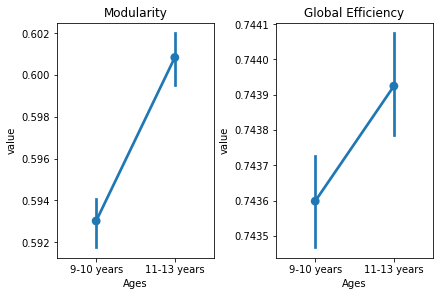

In [20]:
fig,ax = plt.subplots(ncols=2, layout='constrained')
sns.pointplot(
    long_mod, 
    y='value',
    x='visit',
    #hue='visit', 
    #multiple='stack', 
    ax=ax[0]
)
sns.pointplot(
    long_eff, 
    y='value',
    x='visit',
    #hue='visit', 
    #multiple='stack', 
    ax=ax[1]
)
ax[0].set_title('Modularity')
ax[1].set_title('Global Efficiency')

ax[0].set_xlabel('Ages')
ax[1].set_xlabel('Ages')

ax[0].set_xticklabels(['9-10 years', '11-13 years'])
ax[1].set_xticklabels(['9-10 years', '11-13 years'])
#ax.axvline(long_mod[long_mod['visit'] == 'baseline_year_1_arm_1'])

In [21]:
from scipy.stats import ttest_rel
ttest_rel(
    graph_df.dropna()[('2_year_follow_up_y_arm_1','modularity')],
    graph_df.dropna()[('baseline_year_1_arm_1','modularity')]
)

Ttest_relResult(statistic=9.236720633178013, pvalue=3.251746520716789e-20)

In [22]:
graph_df.describe()

baseline_year_1_arm_1               2_year_follow_up_y_arm_1  \
          global_efficiency    modularity        global_efficiency   
count          11187.000000  11187.000000              7503.000000   
mean               0.743599      0.593015                 0.743924   
std                0.007013      0.060526                 0.006346   
min                0.602564      0.087771                 0.608974   
25%                0.741453      0.560754                 0.741453   
50%                0.745726      0.601199                 0.745726   
75%                0.747863      0.634311                 0.747863   
max                0.750000      0.761739                 0.750000   

                    
        modularity  
count  7503.000000  
mean      0.600841  
std       0.053726  
min       0.199650  
25%       0.572418  
50%       0.606767  
75%       0.636928  
max       0.779948

In [23]:
sign_change = pd.DataFrame(index=ppts, columns=conns, dtype=float)
change = pd.DataFrame(index=ppts, columns=conns, dtype=float)
change_abs = pd.DataFrame(index=ppts, columns=conns, dtype=float)
change_plus1 = pd.DataFrame(index=ppts, columns=conns, dtype=float)
rci = pd.DataFrame(index=ppts, columns=conns, dtype=float)
rci_abs = pd.DataFrame(index=ppts, columns=conns, dtype=float)

for i in ppts:
    if i not in base_df.index or i not in y2fu_df.index:
        pass
    else:
        age0 = df.loc[i, 'interview_age.baseline_year_1_arm_1'] / 12.
        age2 = df.loc[i, 'interview_age.2_year_follow_up_y_arm_1'] / 12.
        for conn in conns:
            base = base_df.loc[i, conn]
            y2fu = y2fu_df.loc[i, conn]
            
            temp = pd.concat([base_df[conn], y2fu_df[conn]])
            
            sem = np.std(temp.values, ddof=1) / np.sqrt(np.size(temp.values))
            abs_sem = np.std(np.abs(temp.values), ddof=1) / np.sqrt(np.size(temp.values))
            
            rci.at[i,conn] = (y2fu - base) / sem
            rci_abs.at[i,conn] = (np.abs(y2fu) - np.abs(base)) / abs_sem
            #print(base * y2fu)
            if base * y2fu > 0:
                if y2fu > 0:
                    sign_change.at[i, conn] = '+ to +'
                else:
                    sign_change.at[i, conn] = '- to -'
            else:
                if y2fu > 0:
                    sign_change.at[i, conn] = '- to +'
                else:
                    sign_change.at[i, conn] = '+ to -'
            # calc change in raw corr
            change.at[i, conn] = (((y2fu - base) / np.mean([y2fu, base])) * 100) / (age2 - age0)

            # calc change in absolute z-scored correlation
            change_abs.at[i, conn] = (((np.abs(y2fu) - np.abs(base)) / np.mean([np.abs(y2fu), np.abs(base)])) * 100) / (age2 - age0)

            # calc change in corr + 1
            base_plus1 = np.tanh(base) + 1
            y2fu_plus1 = np.tanh(y2fu) + 1
            change_plus1.at[i, conn] = (((y2fu_plus1 - base_plus1) / np.mean([y2fu_plus1, base_plus1])) * 100) / (age2 - age0)

In [24]:
sign_change.to_csv(join(PROJ_DIR, DATA_DIR, 'sign_changes.csv'))

In [25]:
long_corr = pd.concat(
    [
        change.melt(), 
        sign_change.melt(value_name='sign change').drop('variable',axis=1)
    ], 
    axis=1
)
long_corr['score'] = ['z(corr)'] * 696111

long_abs = pd.concat(
    [
        change_abs.melt(), 
        sign_change.melt(value_name='sign change').drop('variable',axis=1)
    ], 
    axis=1
)
long_abs['score'] = ['abs(z(corr))'] * 696111
long_rci = pd.concat(
    [
        rci.melt(), 
        sign_change.melt(value_name='sign change').drop('variable',axis=1)
    ], 
    axis=1
)
long_rci['score'] = ['rci'] * 696111
long_rci_abs = pd.concat(
    [
        rci_abs.melt(), 
        sign_change.melt(value_name='sign change').drop('variable',axis=1)
    ], 
    axis=1
)
long_rci_abs['score'] = ['abs(rci)'] * 696111
long_plus1 = pd.concat(
    [
        change_plus1.melt(), 
        sign_change.melt(value_name='sign change').drop('variable',axis=1)
    ], 
    axis=1
)
long_plus1['score'] = ['corr + 1'] * 696111

In [36]:
network_wise['ad']

['rsfmri_c_ngd_ad_ngd_ad',
 'rsfmri_c_ngd_ad_ngd_cgc',
 'rsfmri_c_ngd_ad_ngd_ca',
 'rsfmri_c_ngd_ad_ngd_dt',
 'rsfmri_c_ngd_ad_ngd_dla',
 'rsfmri_c_ngd_ad_ngd_fo',
 'rsfmri_c_ngd_ad_ngd_n',
 'rsfmri_c_ngd_ad_ngd_rspltp',
 'rsfmri_c_ngd_ad_ngd_sa',
 'rsfmri_c_ngd_ad_ngd_smh',
 'rsfmri_c_ngd_ad_ngd_smm',
 'rsfmri_c_ngd_ad_ngd_vta',
 'rsfmri_c_ngd_ad_ngd_vs']

In [24]:
mega_df = pd.concat([
    long_corr,
    long_rci,
    long_abs, 
    long_rci_abs, 
    long_plus1
                    ])

In [25]:
mega_df

,variable,value,sign change,score
0,rsfmri_c_ngd_ad_ngd_ad,-11.853509,+ to +,z(corr)
1,rsfmri_c_ngd_ad_ngd_ad,8.617952,+ to +,z(corr)
2,rsfmri_c_ngd_ad_ngd_ad,9.011532,+ to +,z(corr)
3,rsfmri_c_ngd_ad_ngd_ad,1.581073,+ to +,z(corr)
4,rsfmri_c_ngd_ad_ngd_ad,-22.208185,+ to +,z(corr)
...,...,...,...,...
696106,rsfmri_c_ngd_vs_ngd_vs,4.886277,+ to +,corr + 1
696107,rsfmri_c_ngd_vs_ngd_vs,1.358025,+ to +,corr + 1
696108,rsfmri_c_ngd_vs_ngd_vs,-1.519464,+ to +,corr + 1
696109,rsfmri_c_ngd_vs_ngd_vs,3.195195,+ to +,corr + 1


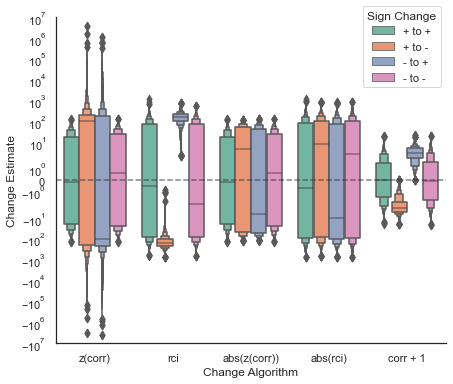

In [34]:
# also plot the raw correlation differences
# and another plot of sign changes|
# maybe also correlation changes by sign change

sns.set(style='white')
fig,ax = plt.subplots(figsize=(7,6))
sns.boxenplot(
    mega_df.reset_index(),
    y='value',
    x='score',
    hue='sign change',
    #hue_order=['z(corr)', 'abs(z(corr))', 'rci', 'abs(rci)', 'corr + 1'],
    #color='#d95f02', #orange
    #fill=True,
    ax=ax,
    palette='Set2'
)
ax.set_yscale("symlog")
ax.set_ylim(bottom=-(10**7), top=10**7)
ax.set_ylabel('Change Estimate')
ax.set_xlabel('Change Algorithm')
ax.legend(bbox_to_anchor=(1,1.05), title='Sign Change')
ax.axhline(0, color='#333333', linestyle='dashed', alpha=0.6)
sns.despine()

<AxesSubplot:xlabel='value', ylabel='Density'>

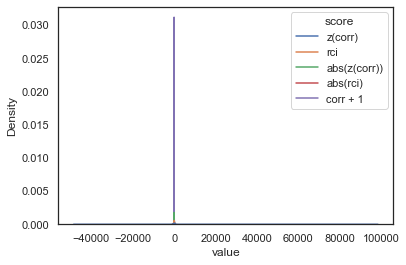

In [36]:
sns.kdeplot(
    mega_df[mega_df['variable'] == 'rsfmri_c_ngd_ad_ngd_dt'].reset_index(), 
    x='value',
    hue='score'
)

In [37]:
nifti_mapping = pd.read_csv('/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/data/variable_to_nifti_mapping.csv', 
                                header=0, 
                                index_col=0)

In [38]:
nifti_mapping.loc[between_network['ad']]['atlas_fname'][0]

TypeError: list indices must be integers or slices, not str

In [39]:
gordon = nib.load('/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/resources/gordon_networks_222.nii')

In [40]:
network_arr = gordon.get_fdata()

In [41]:
network_vals = nifti_mapping[nifti_mapping['atlas'] == 'Gordon Networks']['atlas_value']

In [42]:
network_vals = [(i.split('_')[3], network_vals[i]) for i in network_vals.index]

In [43]:
ntwk_df = pd.Series()

for i in range(0, len(network_vals)):
    ntwk_df.at[network_vals[i][0]] = network_vals[i][1]

In [48]:
ntwks = {}
ntwk_conns = {}
ntwk_niftis = {}
for ntwk in network_wise.keys():
    ntwks[ntwk] = rci.describe()[network_wise[ntwk]].T
    ntwks[ntwk].index = [i.split('_')[-1] for i in ntwks[ntwk].index]
    ntwk_conns[ntwk] = np.zeros_like(network_arr)
    for i in ntwks[ntwk].index:
        val = ntwk_df[i]
        ntwk_conns[ntwk][np.where(network_arr == val)] = ntwks[ntwk].loc[i]['mean']
    ntwk_niftis[ntwk] = nib.Nifti2Image(ntwk_conns[ntwk], gordon.affine)

In [49]:
ntwks['n']

,count,mean,std,min,25%,50%,75%,max
ad,4099.0,-2.533871,147.209862,-659.294142,-97.922570,-0.520100,95.771389,498.430778
cgc,4099.0,-4.402904,138.274392,-477.968806,-95.342857,-4.698273,87.714746,501.404821
ca,4099.0,-19.799560,139.975644,-518.809020,-110.752395,-18.142266,72.652701,576.736485
dt,4099.0,-14.025925,120.929900,-494.193869,-93.478668,-15.349399,61.669287,561.213672
dla,4099.0,-2.387799,133.585809,-621.049682,-87.335738,-1.421209,84.300197,582.248261
fo,4099.0,-15.276766,142.110454,-512.352457,-106.727044,-11.568517,74.822393,583.321451
n,4099.0,-27.569491,124.262977,-608.898228,-104.434767,-26.241898,49.483307,1163.116310
rspltp,4099.0,-13.280981,133.923647,-514.519655,-100.500093,-13.222792,76.060863,500.389906
sa,4099.0,-3.446552,136.562168,-539.175039,-95.043244,-2.881264,85.893000,566.771960
smh,4099.0,-20.590571,143.444823,-701.001295,-112.872329,-18.545741,73.447019,688.614154


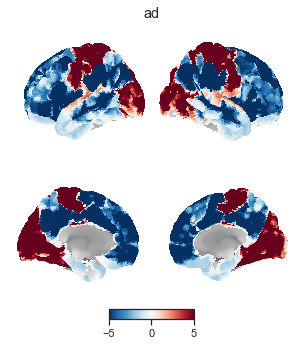

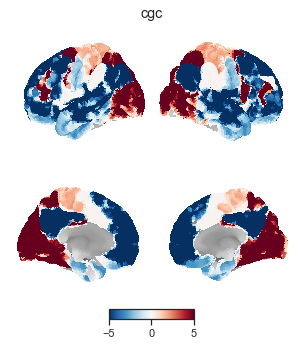

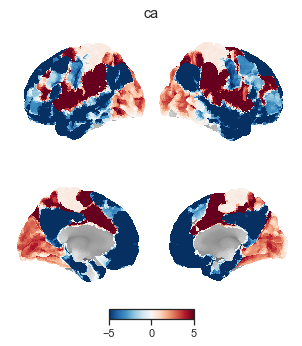

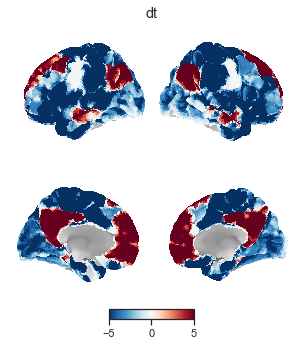

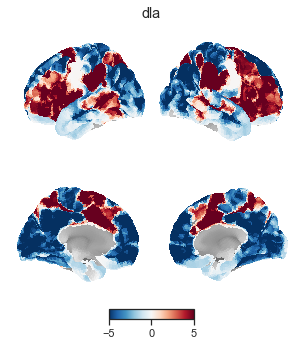

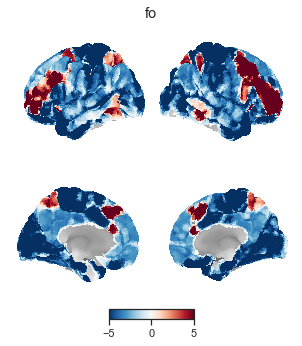

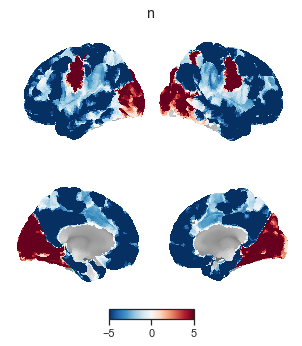

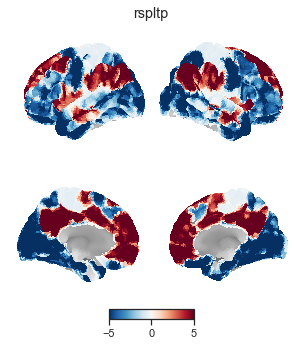

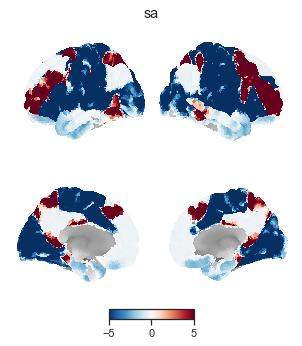

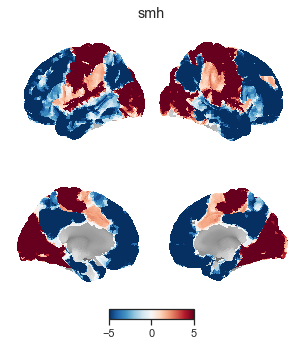

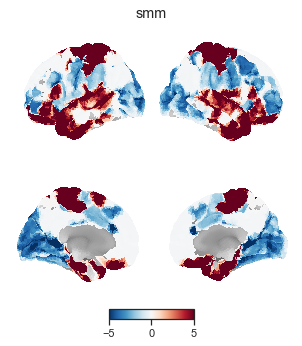

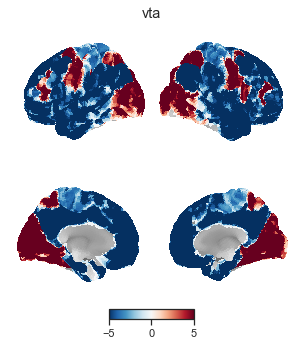

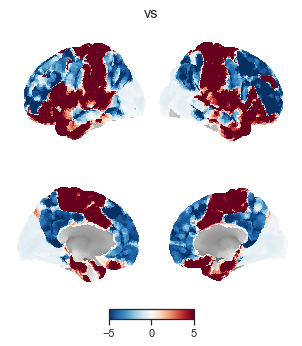

In [50]:
for ntwk in ntwk_niftis.keys():
    temp = ntwk_niftis[ntwk]
    plotting.plot_img_on_surf(
        temp, 
        threshold=0.01, 
        cmap='RdBu_r', 
        title=ntwk,
        vmax=5,
        kwargs=dict(alpha=0.6)
    )

## Now repeat for change in z